In [1]:
import os
import zipfile
import time
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd
from momepy import close_gaps, extend_lines

from sqlalchemy import create_engine

# set up database
user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(db_connection_url)

In [2]:
sql = '''SELECT table_name
  FROM information_schema.tables
 WHERE table_schema='public'
   AND table_type='BASE TABLE';'''

tables = pd.read_sql(sql, engine).table_name

print(tables)

0                       spatial_ref_sys
1                             opennames
2                            openrivers
3                             openroads
4                          boundaryline
5                          openmaplocal
6                        opengreenspace
7                              openuprn
8                              opentoid
9     boundary_line_ceremonial_counties
10      boundary_line_historic_counties
11                       community_ward
12                       country_region
13                               county
14            county_electoral_division
15             district_borough_unitary
16        district_borough_unitary_ward
17                       english_region
18                 greater_london_const
19                           high_water
20             historic_european_region
21                               parish
22            polling_districts_england
23             scotland_and_wales_const
24            scotland_and_wales_region


In [3]:
def pgselect(table, buffer=400, x=338286, y=392077):
    user = os.environ.get('DB_USERNAME')
    pwd = os.environ.get('DB_PASSWORD')
    host = os.environ.get('DB_HOSTNAME')
    port = os.environ.get('DB_PORT')

    url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
    engine = create_engine(url)
    sql = f'SELECT * FROM {table} WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [6]:
coastline = gpd.read_postgis('SELECT * FROM coastline', engine, geom_col='geometry')

In [7]:
rivers = gpd.read_postgis('SELECT * FROM rivers', engine, geom_col='geometry')

In [8]:
rwys = gpd.read_postgis('SELECT * FROM railways', engine, geom_col='geometry')

In [9]:
roads = gpd.read_postgis('SELECT * FROM openroads', engine, geom_col='geometry')

In [10]:
import pygeos
from shapely.ops import polygonize
from momepy import close_gaps, extend_lines

In [35]:
rwys.classification.unique()

array(['Narrow Gauge', 'Single Track', 'Multi Track'], dtype=object)

In [32]:
roads.roadFunction.unique()

array(['Local Road', 'Minor Road', 'Restricted Local Access Road',
       'B Road', 'Local Access Road', 'A Road', 'Secondary Access Road',
       'Motorway'], dtype=object)

In [33]:
mwy = roads.loc[roads.roadFunction == 'Motorway']

In [38]:
ards = roads.loc[roads.roadFunction == 'A Road']

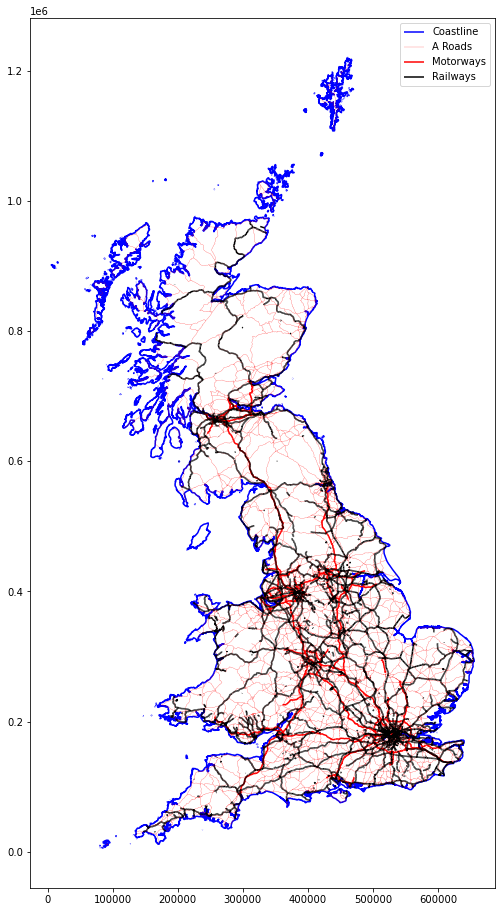

In [52]:
fig, ax = plt.subplots(figsize=(16,16))
# countries.plot(ax=ax, color='k')
coastline.plot(ax=ax, color='blue')

# rivers.plot(ax=ax, linewidth=0.2, color='blue')
ards.plot(ax=ax, color='red', linewidth=0.2)
mwy.plot(ax=ax, color='red', legend=True)
rwys.plot(ax=ax, color='k', legend=True)
ax.legend(labels=['Coastline', 
#                   'Rivers', 
                  'A Roads', 'Motorways', 'Railways'])

<AxesSubplot:>

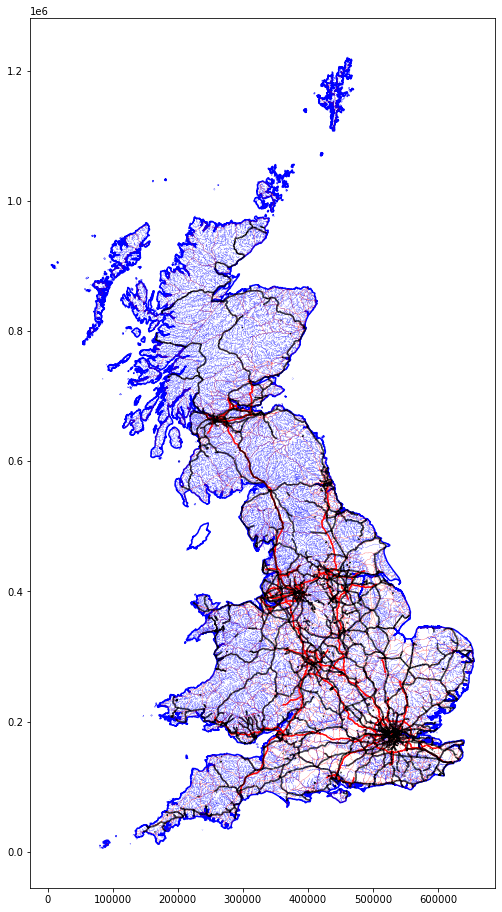

In [53]:
# algorithm goes like this
# get unary_union
# polygonize(union)
# enclosures = gpd.array.from_shapely(list(polygons), crs=...)
# gpd.GeoDataFrame(geometry=enclosures)